In [1]:
# from google.colab import files

# uploaded = files.upload()

# importing Libraries

In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer


In [3]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM , Conv1D , MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score
import tensorflow as tf

# Exploring Fake News

In [4]:
fake = pd.read_csv('Fake.csv')
real = pd.read_csv('True.csv')

In [5]:
fake.head()

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"


In [6]:
fake['subject'].value_counts()

,count
subject,
News,9050
politics,6841
left-news,4459
Government News,1570
US_News,783
Middle-east,778


In [7]:
real['subject'].value_counts()

,count
subject,
politicsNews,11272
worldnews,10145


<Axes: xlabel='subject', ylabel='count'>

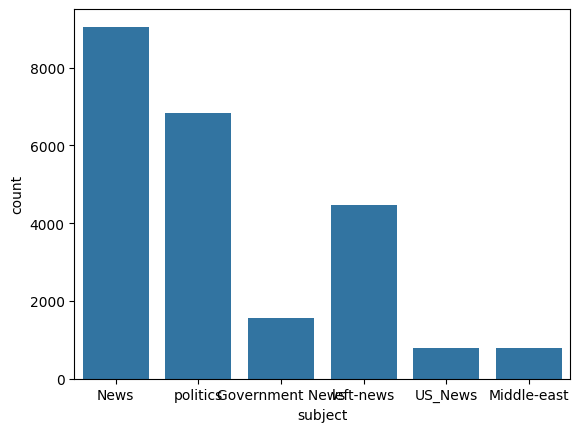

In [8]:
sns.countplot(x='subject', data=fake )

# Word Cloud

In [9]:
fake_news_text = ' '.join(fake['text'].tolist())

In [ ]:
wordcloud = WordCloud(width=1920 , height= 1080).generate(fake_news_text)
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# Exploring the real new dataset




In [11]:
real_news_text = ' '.join(fake['text'].tolist())

<Axes: xlabel='subject', ylabel='count'>

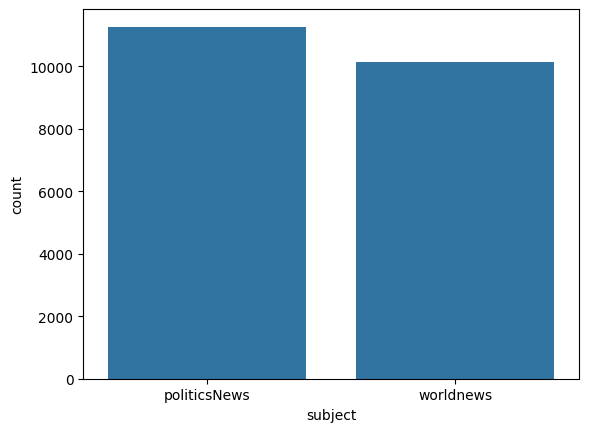

In [12]:
sns.countplot(x='subject', data=real )

In [ ]:
wordcloud = WordCloud(width=1920 , height= 1080).generate(real_news_text)
fig = plt.figure(figsize=(10,10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

# Diffrences in Text
> Real news seems to have source of publication which is not present in fake news set

> Looking at the data:
  - most of the text contains reuters information such as "WASHINGTON (Reuters)"
  - Some text are tweets from Twitter
  - Few text do not contain any publication


# Cleaning Data

Removinf Reuters or Twitter information from the text
- Text can be splitted only once at "-" whcih is always present after mentoring source of publication, this gives us publication part and text part
- if we do not get text part this means publication details wasn't given for that record
- The Twitter tweets always have same source , a long text of max 259 characters

In [14]:
real.sample(5)

,title,text,subject,date
13541,Iran denies airspace access to Bulgarian PM's ...,SOFIA (Reuters) - Iran denied access to its ai...,worldnews,"November 29, 2017"
14408,Satellite calls yield no clues on missing Arge...,"MAR DEL PLATA, Argentina (Reuters) - A storm o...",worldnews,"November 19, 2017"
1391,NRA calls for more regulation after Vegas shoo...,WASHINGTON (Reuters) - The National Rifle Asso...,politicsNews,"October 5, 2017"
17165,"Kosovo urges U.S. involvement in Belgrade, Pri...",(This version of the October 15 story correct...,worldnews,"October 16, 2017"
15321,Argentina congress passes law to fight corpora...,BUENOS AIRES (Reuters) - Argentina s congress ...,worldnews,"November 8, 2017"


In [15]:
unknown_publisher = []
for index , row in enumerate(real.text.values):
  try:
    record = row.split('-', maxsplit = 1)
    record[1]

    assert(len(record[0]) < 120)
  except:
    unknown_publisher.append(index)


In [16]:
len(unknown_publisher)

222

In [17]:
real.iloc[unknown_publisher]['text']

,text
7,The following statements were posted to the ve...
8,The following statements were posted to the ve...
12,The following statements were posted to the ve...
13,The following statements were posted to the ve...
14,"(In Dec. 25 story, in second paragraph, corre..."
...,...
20135,(Story corrects to million from billion in pa...
20500,"(This Sept 8 story corrects headline, clarifi..."
20667,"(Story refiles to add dropped word not , in ..."
21246,(Story corrects third paragraph to show Mosul...


In [18]:
real.iloc[8970]

,8970
title,Graphic: Supreme Court roundup
text,
subject,politicsNews
date,"June 16, 2016"


In [19]:
real.drop(8970 , inplace = True)

In [20]:
publisher = []
tmp_text = []

for index , row in enumerate(real['text'].values):
  if index in unknown_publisher:
    tmp_text.append(row)
    publisher.append('Unknown')
    continue
  else:
    record = row.split('-', maxsplit = 1)
    publisher.append(record[0].strip())
    tmp_text.append(record[1].strip())

In [21]:
real['publisher'] = publisher
real['text'] = tmp_text


In [22]:
(real.head())


,title,text,subject,date,publisher
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017",WASHINGTON (Reuters)
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017",WASHINGTON (Reuters)
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters)


In [23]:
print(real.shape)

(21416, 5)


In [24]:
empty_fake_index = [index for index , text in enumerate (fake['text'].tolist()) if str(text).strip() == ""]

In [25]:
fake.iloc[empty_fake_index]

,title,text,subject,date
10923,TAKE OUR POLL: Who Do You Think President Trum...,,politics,"May 10, 2017"
11041,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,"Apr 26, 2017"
11190,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,"Apr 6, 2017"
11225,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,politics,"Apr 2, 2017"
11236,SHOCKER: Public School Turns Computer Lab Into...,,politics,"Apr 1, 2017"
...,...,...,...,...
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015"
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015"
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015"
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015"


In [26]:
real['text'] = real['title'] + " " + real["text"]
fake['text'] = fake['title'] + " " + fake["text"]

In [27]:
real['text'] = real['text'].apply(lambda x : str(x).lower())
fake['text'] = fake['text'].apply(lambda x : str(x).lower())

# Preprcessing text

In [28]:
real['class'] = 1
fake['class'] = 0

In [29]:
real = real[['text' , 'class']]
fake = fake[['text' , 'class']]



In [30]:
real

,text,class
0,"as u.s. budget fight looms, republicans flip t...",1
1,u.s. military to accept transgender recruits o...,1
2,senior u.s. republican senator: 'let mr. muell...,1
3,fbi russia probe helped by australian diplomat...,1
4,trump wants postal service to charge 'much mor...,1
...,...,...
21412,'fully committed' nato backs new u.s. approach...,1
21413,lexisnexis withdrew two products from chinese ...,1
21414,minsk cultural hub becomes haven from authorit...,1
21415,vatican upbeat on possibility of pope francis ...,1


In [31]:
fake

,text,class
0,donald trump sends out embarrassing new year’...,0
1,drunk bragging trump staffer started russian ...,0
2,sheriff david clarke becomes an internet joke...,0
3,trump is so obsessed he even has obama’s name...,0
4,pope francis just called out donald trump dur...,0
...,...,...
23476,mcpain: john mccain furious that iran treated ...,0
23477,justice? yahoo settles e-mail privacy class-ac...,0
23478,sunnistan: us and allied ‘safe zone’ plan to t...,0
23479,how to blow $700 million: al jazeera america f...,0


In [32]:
data = pd.concat([real, fake], ignore_index=True)


In [33]:
data.sample(5)

,text,class
44369,msnbc #fakenews fail: desperate rachel maddow ...,0
10837,justice scalia received last rites from cathol...,1
33745,ma college removes and burns american flag to ...,0
3884,judges hit trump lawyer with tough questions o...,1
43945,us media hyped ‘active shooter’ drill at andre...,0


In [34]:
# !pip install spacy==3.8.2
# !python -m spacy download en_core_web_sm
# !pip install beautifulsoup4==4.9.1
# !pip install textblob==0.15.3
# !pip install git+https://github.com/laximerit/preprocess_kgptalkie.git --upgrade --force-reinstall


In [35]:
# !pip install preprocess-kgptalkie


In [36]:
# !pip install googletrans==4.0.0-rc1


In [37]:
import preprocess_kgptalkie as ps




In [38]:
data['text'] = data['text'].apply(lambda x: ps.remove_special_chars(x))

In [39]:
import re
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')

stop_words = set(stopwords.words('english'))

def remove_stopwords(text):
    tokens = re.findall(r'\b\w+\b', text.lower())
    return " ".join([word for word in tokens if word not in stop_words])

data['text'] = data['text'].apply(remove_stopwords)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


# Vectorization -- Word2Vec

In [40]:
# !pip install --upgrade --force-reinstall numpy gensim


In [41]:
import gensim

In [42]:
y = data['class'].values

In [84]:
X = [d.split() for d in data['text'].tolist()]

In [85]:
DIM = 100
w2v_model = gensim.models.Word2Vec(sentences=X, vector_size=DIM, window=5, min_count=1)

In [45]:
w2v_model.wv.most_similar('india')

[('pakistan', 0.7339564561843872),
 ('malaysia', 0.6808139681816101),
 ('philippines', 0.6613020300865173),
 ('japan', 0.6380113363265991),
 ('indias', 0.6378080248832703),
 ('thailand', 0.637206494808197),
 ('china', 0.6349048614501953),
 ('indonesia', 0.6218131184577942),
 ('triglobal', 0.6092948913574219),
 ('beijings', 0.6070520281791687)]

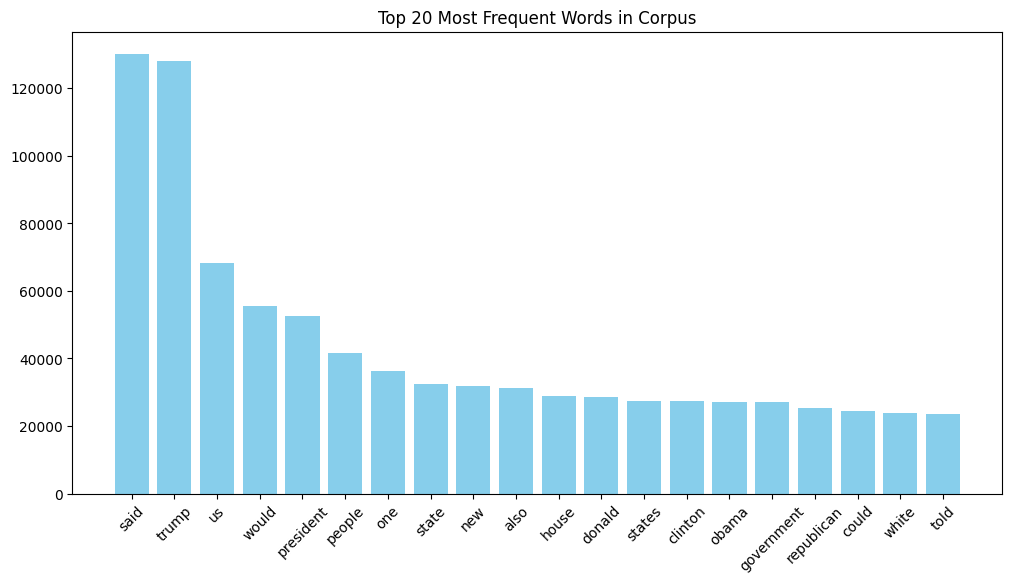

In [46]:
from collections import Counter

all_tokens = [word for sentence in X for word in sentence]

# Count word frequencies
word_freq = Counter(all_tokens)

# Get top 20 most frequent words
common_words = word_freq.most_common(20)
words, counts = zip(*common_words)

# Plot frequency bar chart
plt.figure(figsize=(12,6))
plt.bar(words, counts, color="skyblue")
plt.xticks(rotation=45)
plt.title("Top 20 Most Frequent Words in Corpus")
plt.show()

In [86]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

In [87]:
X = tokenizer.texts_to_sequences(X)

In [88]:
maxlen = 1000
X = pad_sequences(X, maxlen=maxlen)

In [89]:
vocab_size = len(tokenizer.word_index) + 1

In [90]:
vocab = tokenizer.word_index

In [91]:
def get_weight_matrix(model):
    weight_matrix = np.zeros((vocab_size, DIM))
    for word, i in tokenizer.word_index.items():
        weight_matrix[i] = model.wv[word]
    return weight_matrix

In [92]:
embedding_vectors = get_weight_matrix(w2v_model)

In [54]:
embedding_vectors.shape

(230703, 100)

# Comparison between the three embedding types
- Word2Vec
- GLOVE
- FastText


In [75]:
import numpy as np
import pandas as pd
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from gensim.models import Word2Vec, FastText
import gensim.downloader as api


In [76]:

# =============== Data ===============
y = data['class'].values
texts = data['text'].astype(str).tolist()


In [77]:
# =============== Tokenizer ===============
tokenizer = Tokenizer(num_words=10000)   # limit vocab for speed
tokenizer.fit_on_texts(texts)
sequences = tokenizer.texts_to_sequences(texts)
maxlen = 100
X_pad = pad_sequences(sequences, maxlen=maxlen)

word_index = tokenizer.word_index
vocab_size = min(10000, len(word_index)) + 1
DIM = 100


In [78]:
# =============== Word2Vec (lighter) ===============
sentences = [t.split() for t in texts]
w2v_model = Word2Vec(sentences=sentences, vector_size=DIM,
                     window=3, min_count=5, workers=2, epochs=3)

# =============== FastText (lighter) ===============
ft_model = FastText(sentences=sentences, vector_size=DIM,
                    window=3, min_count=5, workers=2, epochs=3, sg=1)

In [79]:

# =============== Pretrained GloVe (light version) ===============
# use smaller glove instead of full 6B
glove_model = api.load("glove-wiki-gigaword-100")   # light pretrained GloVe

In [80]:
def get_weight_matrix(model, tokenizer, DIM, is_gensim=True):
    weight_matrix = np.zeros((len(tokenizer.word_index)+1, DIM))
    for word, i in tokenizer.word_index.items():
        if i >= 10000:  # skip words beyond vocab limit
            continue
        if is_gensim:  # Word2Vec / FastText
            if word in model.wv:
                weight_matrix[i] = model.wv[word]
        else:  # GloVe (KeyedVectors)
            if word in model:
                weight_matrix[i] = model[word]
    return weight_matrix

# rebuild weights
w2v_weights = get_weight_matrix(w2v_model, tokenizer, DIM, is_gensim=True)
ft_weights  = get_weight_matrix(ft_model, tokenizer, DIM, is_gensim=True)
glove_weights = get_weight_matrix(glove_model, tokenizer, DIM, is_gensim=False)


In [81]:
def average_embeddings(X_pad, weight_matrix):
    avg_vectors = []
    for seq in X_pad:
        vectors = [weight_matrix[i] for i in seq if i != 0]
        avg_vectors.append(np.mean(vectors, axis=0) if vectors else np.zeros((DIM,)))
    return np.array(avg_vectors)

X_w2v = average_embeddings(X_pad, w2v_weights)
X_ft  = average_embeddings(X_pad, ft_weights)
X_glove = average_embeddings(X_pad, glove_weights)

In [82]:
# =============== Train/Test Split ===============
X_train_w2v, X_test_w2v, y_train, y_test = train_test_split(X_w2v, y, test_size=0.2, random_state=42)
X_train_ft, X_test_ft, _, _ = train_test_split(X_ft, y, test_size=0.2, random_state=42)
X_train_glove, X_test_glove, _, _ = train_test_split(X_glove, y, test_size=0.2, random_state=42)

from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import accuracy_score, classification_report

def evaluate_model(clf, X_train, X_test, y_train, y_test, name):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print(f"\n{name} Embedding Results:")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print(classification_report(y_test, y_pred))

# Logistic Regression
evaluate_model(LogisticRegression(max_iter=500), X_train_w2v, X_test_w2v, y_train, y_test, "Word2Vec + LogisticRegression")
evaluate_model(LogisticRegression(max_iter=500), X_train_ft, X_test_ft, y_train, y_test, "FastText + LogisticRegression")
evaluate_model(LogisticRegression(max_iter=500), X_train_glove, X_test_glove, y_train, y_test, "GloVe + LogisticRegression")

# SVM
evaluate_model(SVC(kernel="linear"), X_train_w2v, X_test_w2v, y_train, y_test, "Word2Vec + SVM")
evaluate_model(SVC(kernel="linear"), X_train_ft, X_test_ft, y_train, y_test, "FastText + SVM")
evaluate_model(SVC(kernel="linear"), X_train_glove, X_test_glove, y_train, y_test, "GloVe + SVM")

# Naïve Bayes
# NB usually expects non-negative counts (e.g., TF-IDF). But you can still try on embeddings.
evaluate_model(MultinomialNB(), X_train_w2v, X_test_w2v, y_train, y_test, "Word2Vec + Naïve Bayes")
evaluate_model(MultinomialNB(), X_train_ft, X_test_ft, y_train, y_test, "FastText + Naïve Bayes")
evaluate_model(MultinomialNB(), X_train_glove, X_test_glove, y_train, y_test, "GloVe + Naïve Bayes")




Word2Vec Embedding Results:
Accuracy: 0.9243875278396436
              precision    recall  f1-score   support

           0       0.94      0.92      0.93      4644
           1       0.91      0.93      0.92      4336

    accuracy                           0.92      8980
   macro avg       0.92      0.92      0.92      8980
weighted avg       0.92      0.92      0.92      8980


FastText Embedding Results:
Accuracy: 0.9103563474387528
              precision    recall  f1-score   support

           0       0.92      0.90      0.91      4644
           1       0.90      0.92      0.91      4336

    accuracy                           0.91      8980
   macro avg       0.91      0.91      0.91      8980
weighted avg       0.91      0.91      0.91      8980


GloVe Embedding Results:
Accuracy: 0.9144766146993318
              precision    recall  f1-score   support

           0       0.92      0.91      0.92      4644
           1       0.91      0.92      0.91      4336

    accurac

# LSTM

In [55]:
model = Sequential()
model.add(Embedding(vocab_size, DIM, input_length=maxlen, weights=[embedding_vectors], trainable=False))
model.add(LSTM(units = 128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [56]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding (Embedding)           │ ?                      │    23,070,300 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm (LSTM)                     │ ?                      │   0 (unbuilt) │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ ?                      │   0 (unbuilt) │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,070,300 (88.01 MB)

 Trainable params: 0 (0.00 B)

 Non-trainable params: 23,070,300 (88.01 MB)

In [93]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [58]:
import torch
print(torch.cuda.is_available())  # True if GPU available
print(torch.cuda.get_device_name(0) if torch.cuda.is_available() else "No GPU")


True
Tesla T4


In [59]:
model.fit(X_train, y_train, validation_split = 0.3 , epochs=4)

Epoch 1/4
786/786 ━━━━━━━━━━━━━━━━━━━━ 34s 39ms/step - accuracy: 0.9204 - loss: 0.1996 - val_accuracy: 0.9711 - val_loss: 0.0822
Epoch 2/4
786/786 ━━━━━━━━━━━━━━━━━━━━ 33s 42ms/step - accuracy: 0.9757 - loss: 0.0675 - val_accuracy: 0.9853 - val_loss: 0.0460
Epoch 3/4
786/786 ━━━━━━━━━━━━━━━━━━━━ 35s 44ms/step - accuracy: 0.9842 - loss: 0.0455 - val_accuracy: 0.9894 - val_loss: 0.0339
Epoch 4/4
786/786 ━━━━━━━━━━━━━━━━━━━━ 41s 44ms/step - accuracy: 0.9901 - loss: 0.0295 - val_accuracy: 0.9900 - val_loss: 0.0285


In [60]:
y_pred = (model.predict(X_test) > 0.5).astype("int32")

281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step


In [61]:
accuracy_score(y_test, y_pred)

0.9891982182628062

In [62]:
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.99      0.99      0.99      4644
           1       0.99      0.98      0.99      4336

    accuracy                           0.99      8980
   macro avg       0.99      0.99      0.99      8980
weighted avg       0.99      0.99      0.99      8980



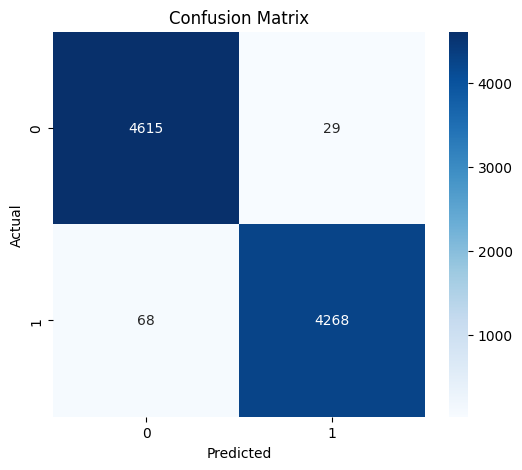

281/281 ━━━━━━━━━━━━━━━━━━━━ 8s 29ms/step


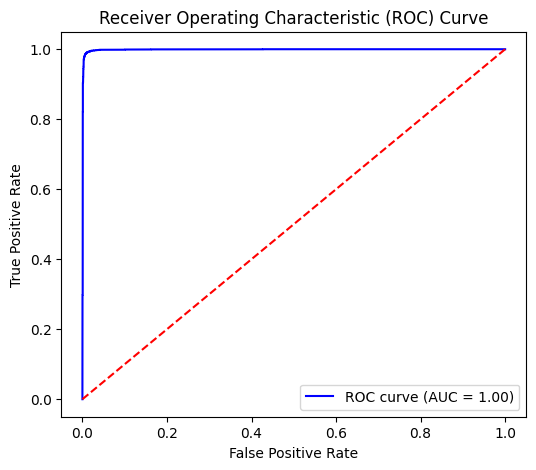

In [66]:
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, roc_curve, auc

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

# ROC Curve
y_pred_proba = model.predict(X_test).ravel()  # probabilities
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve")
plt.legend(loc="lower right")
plt.show()


# GRU

In [94]:
from tensorflow.keras.layers import Embedding, GRU, Dense


In [95]:
gru_model = Sequential()
gru_model.add(Embedding(vocab_size, DIM, input_length=maxlen, weights=[embedding_vectors], trainable=False))
gru_model.add(GRU(units=128))
gru_model.add(Dense(1, activation='sigmoid'))
gru_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train
history = gru_model.fit(X_train, y_train, validation_split=0.2, epochs=4, batch_size=64)

# Predictions
y_pred = (gru_model.predict(X_test) > 0.5).astype("int32").ravel()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/4
449/449 ━━━━━━━━━━━━━━━━━━━━ 22s 43ms/step - accuracy: 0.9133 - loss: 0.2097 - val_accuracy: 0.9716 - val_loss: 0.0805
Epoch 2/4
449/449 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.9821 - loss: 0.0506 - val_accuracy: 0.9932 - val_loss: 0.0197
Epoch 3/4
449/449 ━━━━━━━━━━━━━━━━━━━━ 20s 43ms/step - accuracy: 0.9948 - loss: 0.0158 - val_accuracy: 0.9951 - val_loss: 0.0130
Epoch 4/4
449/449 ━━━━━━━━━━━━━━━━━━━━ 20s 44ms/step - accuracy: 0.9979 - loss: 0.0065 - val_accuracy: 0.9960 - val_loss: 0.0134
281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step


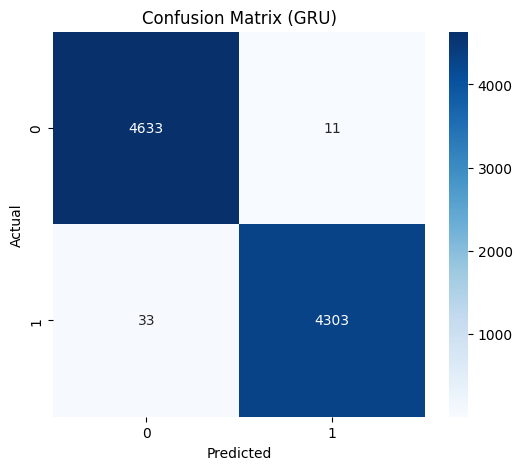

281/281 ━━━━━━━━━━━━━━━━━━━━ 4s 15ms/step


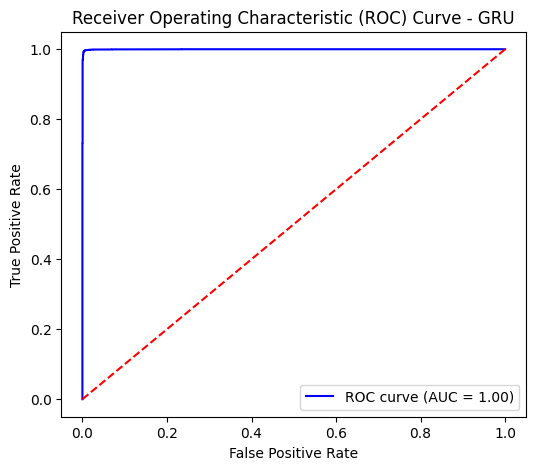

In [96]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (GRU)")
plt.show()

# ======== ROC Curve ========
y_pred_proba = gru_model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve - GRU")
plt.legend(loc="lower right")
plt.show()

# RNN

In [97]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, SimpleRNN, Dense

In [98]:
rnn_model = Sequential()
rnn_model.add(Embedding(vocab_size, DIM, input_length=maxlen, weights=[embedding_vectors], trainable=False))
rnn_model.add(SimpleRNN(units=128))
rnn_model.add(Dense(1, activation='sigmoid'))
rnn_model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Train
history = rnn_model.fit(X_train, y_train, validation_split=0.2, epochs=4, batch_size=64)

# Predictions
y_pred = (rnn_model.predict(X_test) > 0.5).astype("int32").ravel()

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/4
449/449 ━━━━━━━━━━━━━━━━━━━━ 42s 81ms/step - accuracy: 0.8716 - loss: 0.2976 - val_accuracy: 0.8877 - val_loss: 0.2658
Epoch 2/4
449/449 ━━━━━━━━━━━━━━━━━━━━ 35s 76ms/step - accuracy: 0.9174 - loss: 0.2024 - val_accuracy: 0.9246 - val_loss: 0.1962
Epoch 3/4
449/449 ━━━━━━━━━━━━━━━━━━━━ 34s 75ms/step - accuracy: 0.9017 - loss: 0.2376 - val_accuracy: 0.9219 - val_loss: 0.1959
Epoch 4/4
449/449 ━━━━━━━━━━━━━━━━━━━━ 34s 76ms/step - accuracy: 0.9198 - loss: 0.2051 - val_accuracy: 0.8480 - val_loss: 0.3524
281/281 ━━━━━━━━━━━━━━━━━━━━ 6s 20ms/step


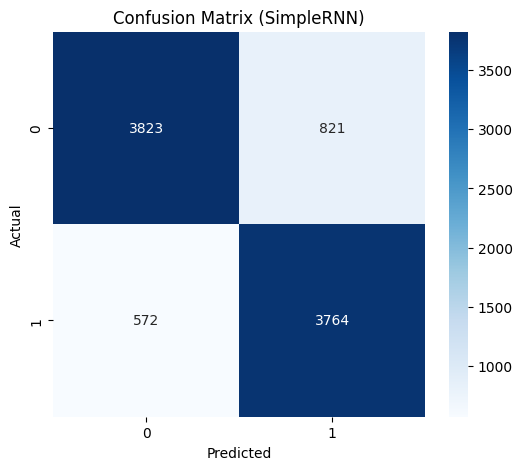

281/281 ━━━━━━━━━━━━━━━━━━━━ 6s 19ms/step


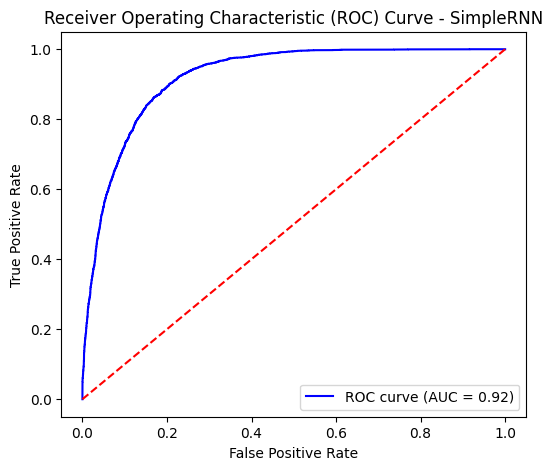

In [99]:
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=[0, 1], yticklabels=[0, 1])
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix (SimpleRNN)")
plt.show()

# ======== ROC Curve ========
y_pred_proba = rnn_model.predict(X_test).ravel()
fpr, tpr, thresholds = roc_curve(y_test, y_pred_proba)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(6, 5))
plt.plot(fpr, tpr, color="blue", label=f"ROC curve (AUC = {roc_auc:.2f})")
plt.plot([0, 1], [0, 1], color="red", linestyle="--")
plt.xlabel("False Positive Rate")
plt.ylabel("True Positive Rate")
plt.title("Receiver Operating Characteristic (ROC) Curve - SimpleRNN")
plt.legend(loc="lower right")
plt.show()